In [1]:
%load_ext autoreload
%autoreload 2    
# Autoreload isn't working for the ssg stuff,
# unclear why, I think it has too many layers of imports.

from collections import namedtuple
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import time
from functools import reduce 
import operator
def prod(iterable):
    return reduce(operator.mul, iterable, 1)

import torch
import torch.distributions.constraints as constraints
import pyro
import pyro.distributions as dist
from pyro.contrib.autoname import scope

from spatial_scene_grammars.nodes import *
from spatial_scene_grammars.rules import *
from spatial_scene_grammars.tree import *
from spatial_scene_grammars.sampling import *
from spatial_scene_grammars.torch_utils import *
from spatial_scene_grammars.neural_grammar_proposal import *

from spatial_scene_grammars_examples.planar_box_stacks.grammar import *

torch.manual_seed(42)

In [2]:
# Make a bigger dataset of observed trees, and prepare meta-tree.
full_trees_for_training = []
observed_nodes_for_training = []
def make_dataset(N=100):
    full_trees = []
    observed_nodes = []
    for k in range(N):
        scene_trees, success = sample_tree_from_root_type_with_constraints(
            root_node_type=Ground,
            root_node_instantiation_dict={
                "xy": dist.Delta(torch.tensor([0., 0.]))
            },
            constraints=[
                NonpenetrationConstraint(0.001),
            ],
            max_num_attempts=1000,
            backend="rejection",#"metropolis_procedural_modeling",
        )
        if not success:
            continue
        full_trees.append(scene_trees[0])
        observed_nodes.append([n for n in scene_trees[0].nodes if isinstance(n, TerminalNode)])
    return full_trees, observed_nodes
full_trees_for_training, observed_nodes_for_training = make_dataset(500)
full_trees_for_testing, observed_nodes_for_testing = make_dataset(250)
meta_tree = SceneTree.make_meta_scene_tree(Ground())

In [3]:
# Load encoder from saved run.
encoder = GrammarEncoder(meta_tree, 512)
weight_path = "saved_models/20210326/encoder_unsupervised_-1.5042.torch"
encoder.load_state_dict(torch.load(weight_path))
encoder.eval()
x = encoder(observed_nodes_for_training[0])

Grammar tuning given a neural proposal engine:

The most direct and appealing approach would be: can I just encode everything in my dataset and convert the meta-tree encoding to grammar encodings? The core question is how to back out the equivalent restricted-grammar params for a set of meta-tree params. Continuous values are already done (the mean-field approx is organized per-node-type). Discrete values require combination across the places the node in question appears in the meat-scene tree: I *think* simple weighted-averaging across the node's appearances will work. Weighting is by how often that node is going to appear in the final grammar, which we can calculate by looking at the parent production probs.

/home/gizatt/miniconda3/envs/py36_pyro/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:563: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/gizatt/miniconda3/envs/py36_pyro/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:660: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


Err:  tensor(203.7194, grad_fn=<SumBackward0>)
Err:  tensor(217.7380, grad_fn=<SumBackward0>)
Err:  tensor(188.7607, grad_fn=<SumBackward0>)
Err:  tensor(190.9450, grad_fn=<SumBackward0>)
Err:  tensor(232.5991, grad_fn=<SumBackward0>)


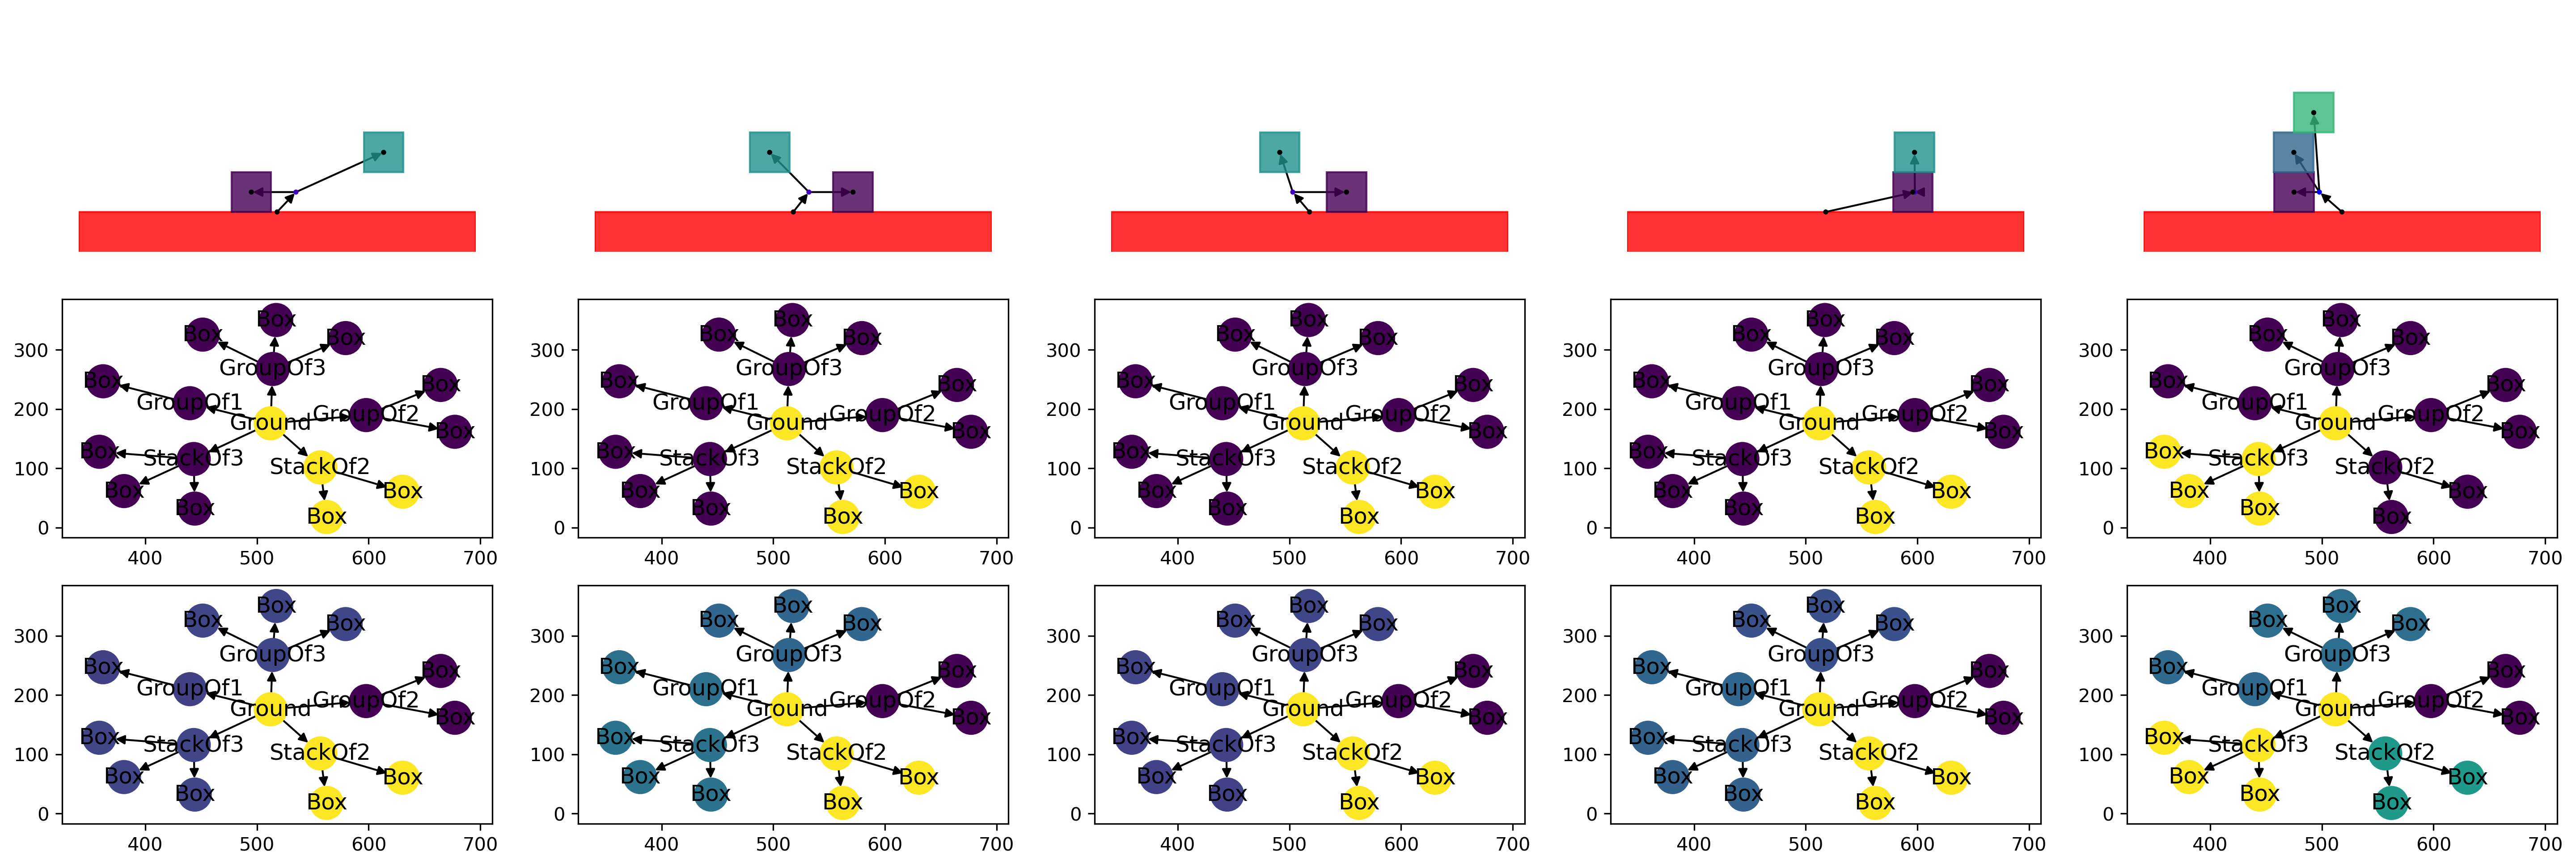

In [4]:
from networkx.drawing.nx_agraph import graphviz_layout
plt.figure(dpi=300).set_size_inches(24, 8)
N = 5
for k in range(N):
    plt.subplot(3, N, k + 1)
    draw_boxes(full_trees_for_training[k], fig=plt.gcf(), ax=plt.gca(), block=False)
    def draw(x):
        inclusion_log_likelihood_per_node, _ = encoder.get_product_weights_and_inclusion_lls(meta_tree, x)
        nx.draw_networkx(
            meta_tree,
            ax=plt.gca(),
            pos = graphviz_layout(meta_tree),
            labels={node: node.__class__.__name__ for node in meta_tree},
            node_color=[inclusion_log_likelihood_per_node[node] for node in meta_tree]
        
    )
    plt.subplot(3, N, N + k + 1)
    x_target = encoder.get_grammar_parameters_from_actual_tree(meta_tree, full_trees_for_training[k])
    draw(x_target)
    plt.subplot(3, N, 2*N + k + 1)
    x = encoder(observed_nodes_for_training[k])
    draw(x)
    
    # Penalize distance for non-nan terms
    target_mask = torch.isfinite(x_target)
    err = (x - x_target)[target_mask].square().sum()
    print("Err: ", err)


Take our encoder directly and try to recover a distribution over the original grammar. This isn't guaranteed to be the (Bayes) optimal distribution, but it'll be heuristically related according to the loss used to train the encoder.

The approach is to optimize the parameters in the original grammar to maximally overlap the original grammar's distribution with the encoded distribution. This is tackled by sampling trees from the encoded distribution, and pushing up on the original grammar's parameters to make those samples more likely. (This is very related to optimizing the ELBO via SVI, but all we're optimizing is parameters of our model, and taking our variational distribution / guide to be fixed.)

In [5]:
# First encode every observation in the training set; the encoder is fixed, so this only needs to be done once.
encodings = [encoder(o) for o in observed_nodes_for_training]
grammar = SceneGrammar(Ground)

# Training
N_EPOCHS = 10
N_EXAMPLES_PER_EPOCH = 10
N_SAMPLES_PER_ENCODING = 3
optimizer = torch.optim.Adam(grammar.parameters(), lr=0.01)
total_objective_history = []
for epoch in range(N_EPOCHS):
    total_objective = 0.
    optimizer.zero_grad()

    # Iterate over part of the observed node set in random order.
    iter_order = torch.randperm(len(observed_nodes_for_training))
    for iter_k in iter_order[:N_EXAMPLES_PER_EPOCH]:
        x = encodings[iter_k]
        for sample_k in range(N_SAMPLES_PER_ENCODING):
            sampled_tree, proposal_density_ll, nonreparam_density_ll = \
                encoder.sample_tree_from_grammar_vector(meta_tree, x)
            proposal_density_ll = proposal_density_ll.detach()
            # Run forward a tree of identical structure under the original
            # grammar (with whatever parameter settings are current).
            tree_ll = grammar.score_tree(sampled_tree)
            total_objective = total_objective + tree_ll

    mean_objective = total_objective / (N_EXAMPLES_PER_EPOCH*N_SAMPLES_PER_ENCODING)
    total_objective_history.append(mean_objective)
    
    if (epoch % 1 == 0):
        print("%d:Mean objective %.2f"
              % (epoch, mean_objective))

    if torch.isfinite(mean_objective):
        (mean_objective).backward()
        optimizer.step()

0:Mean objective 0.00


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn